# TP_2 AUGUSTIN CURINIER

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
plt.style.use('ggplot')

5


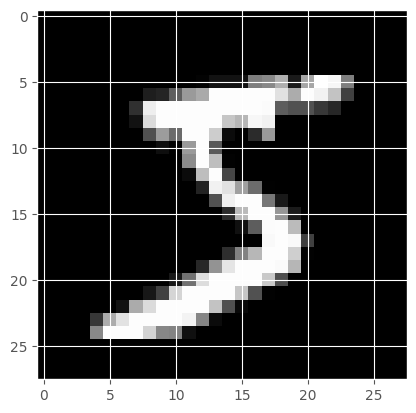

In [67]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

# 4) Model

## 4.1 Number of trainable variables

In [5]:
# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits") # input layer, has 784 nodes, takes 784 digits (representing an image) as an entry, so 1 digit per node
x = layers.Dense(32, activation="relu", name="dense_1")(inputs) # dense_1 layer, has 32 nodes, takes 784 entries so 784*32 = 25k parameters (each node gets 784 params)
x = layers.Dense(32, activation="relu", name="dense_2")(x) # dense_2 layer, has 32 nodes, take 32 entries so 32*32 = 1k parameters (each node gets 32 params)
outputs = layers.Dense(10, activation=None, name="predictions")(x) # output layer, has 10 nodes, take 32 entries so 320 parameters. Output of 10 digits?
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


As we can see above, we are going to train 26 506 variables.

In [7]:
# untrained model
logits = model(x_train) # we feed the raw data (x_train is 60k images of 784 digits) to the model = neural system. We get a 60k*10 matrix: 60k outputs (rows) of len(10) (cols); argmax of output is y_pred.
np.argmax(logits, 1)[0:100] # axis = 1, horizontal! row by row, returns the argmax of each row: contains 60k indexes, 60k y_preds!

array([1, 1, 9, 1, 1, 1, 1, 1, 4, 9, 1, 1, 4, 1, 1, 4, 1, 9, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 9, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 4,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 9, 1, 1, 1, 1, 1, 9, 1, 1,
       1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 9, 1, 1, 1, 9, 1, 1, 1, 3, 4, 1,
       1, 4, 1, 4, 1, 1, 1, 1, 1, 9, 1, 1], dtype=int64)

In [8]:
logits.shape

TensorShape([60000, 10])

In [9]:
np.argmax(logits,1).shape

(60000,)

In [10]:
logits

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[ 1.02339998e-01,  8.86281013e-01, -8.69894251e-02, ...,
         3.50655466e-01,  1.96974188e-01,  2.98384219e-01],
       [ 9.24755877e-05,  5.20752013e-01, -3.30750227e-01, ...,
         2.04582378e-01,  2.16432959e-01,  2.77237266e-01],
       [-3.79951000e-01,  2.87642688e-01, -2.69495755e-01, ...,
        -7.71160647e-02,  9.00931582e-02,  3.98982078e-01],
       ...,
       [-1.16313905e-01,  5.27170539e-01, -4.54639867e-02, ...,
         2.00035185e-01,  4.57271002e-02,  2.54738867e-01],
       [ 1.53944701e-01,  7.45504379e-01,  3.83729823e-02, ...,
         6.44788444e-02, -1.41051218e-01,  1.21430822e-01],
       [-8.48020241e-02,  1.30602881e-01,  5.27602099e-02, ...,
         4.75842915e-02, -2.20330968e-03,  8.91319960e-02]], dtype=float32)>

In [11]:
# what we would like to get
y_train[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

In [12]:
y_train.shape

(60000,)

# Basic functions

In [13]:
## Computing a stochastic gradient

# Source: https://keras.io/guides/writing_a_training_loop_from_scratch/

# Example of gradient computation using automatic differentiation

# x_train is 60k * 784 matrix, y_train is vector of len (60k) containing 60k true y_label values.
x_train_batch = x_train[:8] # we take the first 8 rows (first 8 images) of the train dataset.
y_train_batch = y_train[:8] # we take the corresponding 8 labels!

with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        logits = model(x_train_batch)  # Logits for this minibatch, 8 outputs of len 10. 8*10 matrix! We feed the model the first 8 images!

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits) #compares the argmax of the rows of logits

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss in one point!
grad = tape.gradient(loss_value, model.trainable_weights)

## Updating weights

def update_weights(model_, update, gamma):
    new_weights = model_.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] - gamma*update[i]
    model_.set_weights(new_weights)


## Evaluate model
samples_for_evaluation =
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()


2.3570616

# 5 Stochastic gradient descent

## 5.1 Implementation

In [24]:
# Stochastic gradient algorithm, at first one iteration = update of weights
# gamma0 is the learning rate !

def stochastic_desc(gamma0, batch_size,n_epoch):

    model_temp = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

    objective = []
    iterations = []

    for ep in range(n_epoch):

        print(ep)

        for k in range(0,len(x_train), batch_size):

            x_train_batch_ = x_train[k:batch_size + k]
            y_train_batch_ = y_train[k:batch_size + k]

            with tf.GradientTape() as tape:

                logits_ = model_temp(x_train_batch_)
                # Compute the loss value for this minibatch.

                loss_value_ = loss(y_train_batch_, logits_) #compares the argmax of the rows of logits

                grad_ = tape.gradient(loss_value_, model_temp.trainable_weights)

                samples_for_evaluation_ = np.random.randint(0, 10000, 1000)
                logits_ = model_temp(x_train[samples_for_evaluation_])
                objective_value = loss(y_train[samples_for_evaluation_], logits_).numpy()
                iterations.append(k//batch_size)

                objective.append(objective_value)


                update_weights(model_temp, grad_, gamma0 / np.sqrt(k + 1))

    return objective, iterations


## 5.2 Run for one epoch

In [15]:
loss_list, n_iter = stochastic_desc(0.9,60,1)

In [16]:
samples_for_evaluation = np.random.randint(0, 10000, 1000)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()

0.57063013

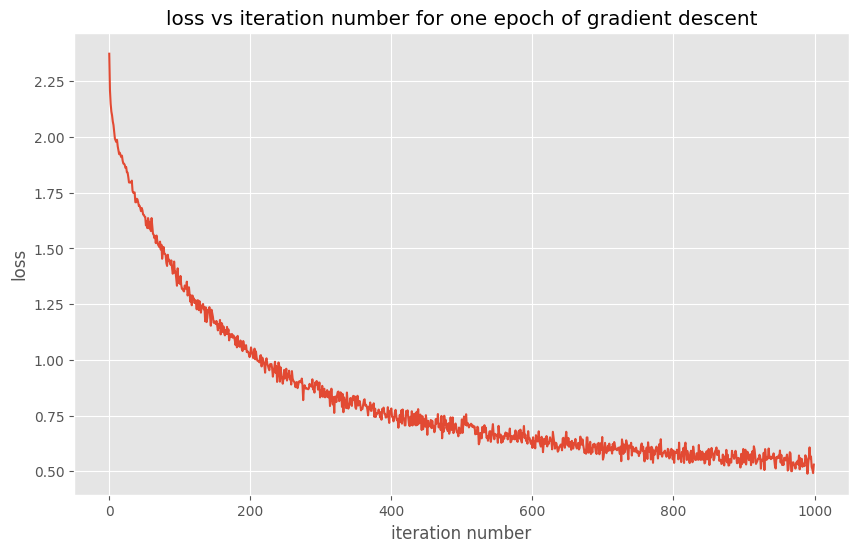

In [17]:
plt.figure(figsize= (10,6))
plt.plot(n_iter, loss_list)
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.title('loss vs iteration number for one epoch of gradient descent')
#plt.savefig('loss_vs_iterations_stochastic_descent_2.png')
plt.show()

In [42]:
# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits") # input layer, has 784 nodes, takes 784 digits (representing an image) as an entry, so 1 digit per node
x = layers.Dense(32, activation="relu", name="dense_1")(inputs) # dense_1 layer, has 32 nodes, takes 784 entries so 784*32 = 25k parameters (each node gets 784 params)
x = layers.Dense(32, activation="relu", name="dense_2")(x) # dense_2 layer, has 32 nodes, take 32 entries so 32*32 = 1k parameters (each node gets 32 params)
outputs = layers.Dense(10, activation=None, name="predictions")(x) # output layer, has 10 nodes, take 32 entries so 320 parameters. Output of 10 digits?
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 6)Risk minimization

## 6.1 10 epoch run

In [275]:
def stochastic_desc_risk(gamma0, batch_size,n_epoch):

    model_temp = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

    objective = []
    iterations = []

    for ep in range(n_epoch):

        for k in range(0,len(x_train), batch_size):

            x_train_batch_ = x_train[k:batch_size + k]
            y_train_batch_ = y_train[k:batch_size + k]

            grad_sum = [0,0,0,0,0,0]


            for j, x_t in enumerate(x_train_batch):

                x_t = (x_t).reshape(1,-1)

                with tf.GradientTape() as tape:

                    logits_ = model_temp(x_t)
                    # Compute this element of the batch

                    loss_value_ = loss(y_train_batch_[j], logits_) #compares the argmax of the rows of logits

                    grad_ = tape.gradient(loss_value_, model_temp.trainable_weights)

                    for l in range(len(grad_sum)):

                        grad_sum[l] = grad_sum[l] + grad_[l]

            samples_for_evaluation_ = np.random.randint(0, 10000, 1000)
            logits_ = model_temp(x_train[samples_for_evaluation_])
            objective_value = loss(y_train[samples_for_evaluation_], logits_).numpy()
            iterations.append(k//batch_size)

            objective.append(objective_value)


        update_weights(model_temp, grad_sum, (gamma0 / np.sqrt(k + 1)*batch_size))


        return objective, iterations

In [43]:
loss_risk, itera = stochastic_desc(0.6,60,10)

0
1
2
3
4
5
6
7
8
9


In [44]:
loss_risk[-1]

0.25542888

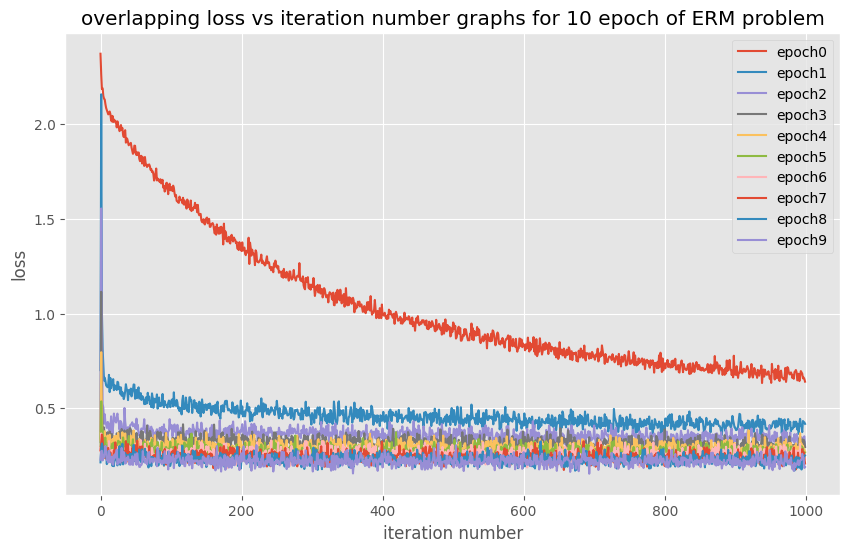

In [37]:
plt.figure(figsize= (10,6))
for d in range(10):
   plt.plot(itera[1000*d:1000*d+1000], loss_risk[1000*d:1000*d+1000],label = 'epoch'+ str(d) )
#plt.plot(itera[:1000], loss_risk[:1000])
#plt.plot(itera[9000:10000], loss_risk[9000:10000])
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.title('overlapping loss vs iteration number graphs for 10 epoch of ERM problem')
plt.savefig('loss_vs_iterations_stochastic_descent_10epoch_overlap.png')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


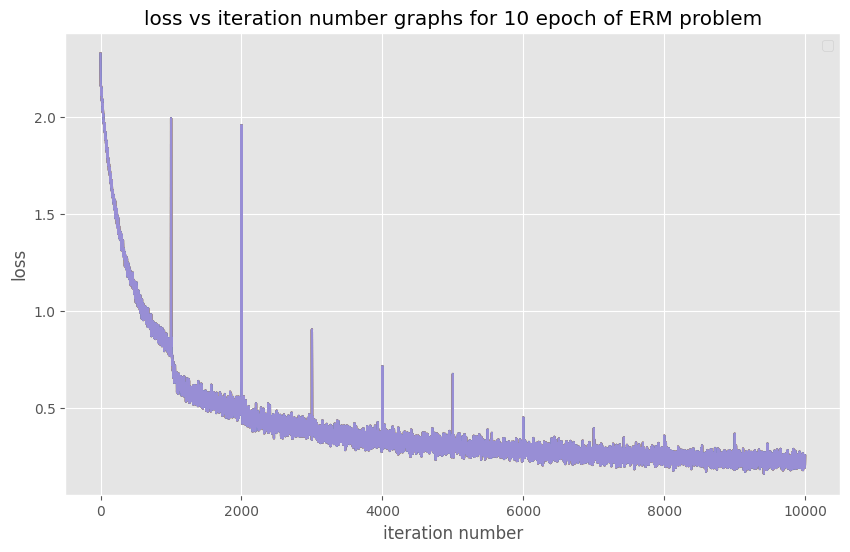

In [45]:
plt.figure(figsize= (10,6))
for d in range(10):
   plt.plot(np.arange(len(loss_risk)), loss_risk )
#plt.plot(itera[:1000], loss_risk[:1000])
#plt.plot(itera[9000:10000], loss_risk[9000:10000])
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.title('loss vs iteration number graphs for 10 epoch of ERM problem')
#plt.savefig('loss_vs_iterations_stochastic_descent_10epoch_.png')
plt.show()

# Test

In [46]:
samples_for_evaluation = np.random.randint(0, 10000, 1000)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()

0.23423916

8
tf.Tensor(
[[ 3.8914433  -4.497199    1.5985606   0.64094687 -0.9278247   3.066895
  -1.0199622  -1.2380731   6.3775716   4.1530023 ]], shape=(1, 10), dtype=float32)


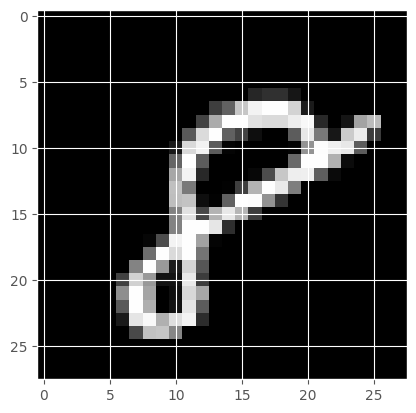

In [70]:
#print(y_train[1])
print(np.argmax(model(x_train[59999].reshape(1,-1))))
print(model(x_train[59999].reshape(1,-1)))
plt.imshow(train_data[0][59999], cmap='gray')

In [61]:
print(y_train[59999])

8


In [65]:
logits = model(x_train)
loss(y_train, logits).numpy()

0.24810421

In [68]:
x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]

In [69]:
logits = model(x_test)
loss(y_test, logits).numpy()

0.24456933

In [ ]:
import random

alea = random.randint(0,9999)

prediction
5
tf.Tensor(
[[ 1.109987   -0.2776167   0.54856664  2.0093684  -2.4836953   5.745571
   5.6361327  -9.115496    2.5782802  -4.7079315 ]], shape=(1, 10), dtype=float32)
true value
6


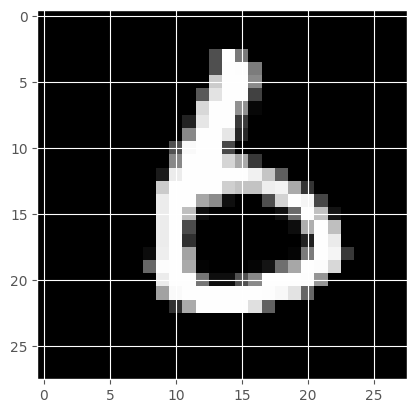

In [107]:
print('prediction')
print(np.argmax(model(x_test[alea].reshape(1,-1))))
print(model(x_test[alea].reshape(1,-1)))
plt.imshow(test_data[0][alea], cmap='gray')
print('true value')
print(y_test[alea])

In [104]:
mistake = 5401

# 7) Evaluation of the model

## 7.1 Accuracy

In [95]:
# accuracy

def accuracy(entry,out):

    correct = 0

    for i,x_ in enumerate(entry):

        pred = np.argmax(model(x_.reshape(1,-1)))

        if pred == out[i]:

            correct += 1

    return correct/len(entry)

In [98]:
train_accu = accuracy(x_train, y_train)

In [99]:
train_accu*len(y_train)

55661.0

In [108]:
test_accu = accuracy(x_test, y_test)

In [110]:
train_accu

0.9276833333333333

In [109]:
test_accu

0.9277

In [111]:
test_accu*len(y_test)

9277.0